Anomalies detected using kNN with threshold distance > 27.059999999999885:
     from   to    cost  community  Anomaly
27    143   10     6.3          0     True
35    169    7   631.5          1     True
51     44    8   789.1          1     True
53     41    7   519.4          1     True
55      8  117   816.2          1     True
56      8   42   759.5          1     True
57      8   41   657.4          1     True
69    162   13   554.5          1     True
72    124    7   763.3          1     True
77      7   40   624.1          1     True
97    101   19   534.4          2     True
138    18    6   499.4          4     True
198   130  106   532.3          5     True
251    72  162  3274.4          8     True
David-Boldin Index: 1.12
Silhouette Score: -0.32


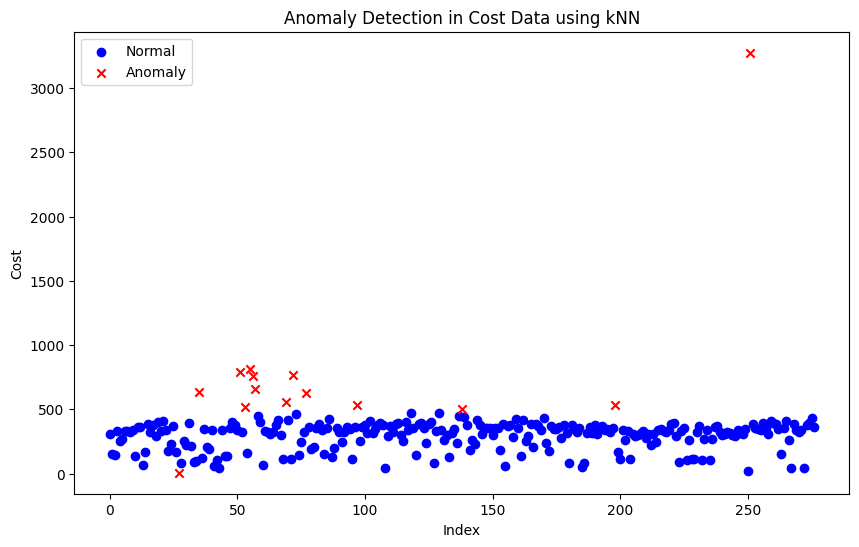

In [1]:
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv('../../data/PEMS08/PEMS08.csv')

df.dropna(inplace=True)

G = nx.from_pandas_edgelist(df, 'from', 'to', ['cost'], create_using=nx.DiGraph)

partition = community_louvain.best_partition(G.to_undirected())

for u, v, d in G.edges(data=True):
    d['community'] = partition[u]


data = []

for community in set(partition.values()):
    edges = [(u, v, d['cost']) for u, v, d in G.edges(data=True) if d['community'] == community]
    costs = [cost for _, _, cost in edges]

    if len(costs) < 2:  
        continue

    for u, v, cost in edges:
        data.append({'from': u, 'to': v, 'cost': cost, 'community': community})


df_anomalies = pd.DataFrame(data)


k = 5  
nbrs = NearestNeighbors(n_neighbors=k).fit(df_anomalies[['cost']])
distances, _ = nbrs.kneighbors(df_anomalies[['cost']])


kth_distances = distances[:, k-1]


distance_threshold = np.percentile(kth_distances, 95)  
df_anomalies['Anomaly'] = kth_distances > distance_threshold


print(f"Anomalies detected using kNN with threshold distance > {distance_threshold}:")
print(df_anomalies[df_anomalies['Anomaly']])


total_z_mean = np.mean(np.abs(zscore(df_anomalies['cost'])))
anomalies_z_mean = np.mean(np.abs(zscore(df_anomalies[df_anomalies['Anomaly']]['cost'])))
david_boldin_index = anomalies_z_mean / total_z_mean

print(f'David-Boldin Index: {david_boldin_index:.2f}')


node_costs_labels = pd.DataFrame([(d['cost'], partition[u]) for u, v, d in G.edges(data=True)], columns=['cost', 'community'])

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(node_costs_labels[['cost']], node_costs_labels['community'])
print(f'Silhouette Score: {silhouette_avg:.2f}')


plt.figure(figsize=(10, 6))
normal_points = df_anomalies[df_anomalies['Anomaly'] == False]
anomalies_points = df_anomalies[df_anomalies['Anomaly'] == True]
plt.scatter(normal_points.index, normal_points['cost'], c='blue', marker='o', label='Normal')
plt.scatter(anomalies_points.index, anomalies_points['cost'], c='red', marker='x', label='Anomaly')
plt.xlabel('Index')
plt.ylabel('Cost')
plt.title('Anomaly Detection in Cost Data using kNN')
plt.legend()
plt.show()
